In [45]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder



In [28]:
model = SentenceTransformer('finetuned_embed_model')

In [29]:
df = pd.read_csv(r"input-files\train.csv")
df.head(5)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [30]:
df = df.dropna(subset=["QuestionText", "MC_Answer", "StudentExplanation", "Category"])

df["input_text"] = (
    "Question: " + df["QuestionText"].astype(str).str.strip() + " " +
    "Answered: " + df["MC_Answer"].astype(str).str.strip() + " " +
    "Explanation: " + df["StudentExplanation"].astype(str).str.strip()
)
training_df = df[["input_text", "Category"]]


In [22]:
training_df.info()
training_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36696 entries, 0 to 36695
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   input_text  36696 non-null  object
 1   Category    36696 non-null  object
dtypes: object(2)
memory usage: 573.5+ KB


,input_text,Category
0,Question: What fraction of the shape is not sh...,True_Correct
1,Question: What fraction of the shape is not sh...,True_Correct
2,Question: What fraction of the shape is not sh...,True_Neither
3,Question: What fraction of the shape is not sh...,True_Neither
4,Question: What fraction of the shape is not sh...,True_Correct


In [23]:
training_df.to_csv("input-files/training_data.csv")

In [31]:
X = model.encode(training_df["input_text"].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 1147/1147 [09:30<00:00,  2.01it/s]


In [33]:
embed_df = pd.DataFrame(X, columns=[f"emb_{i}" for i in range(X.shape[1])])

In [34]:
final_df = pd.concat([training_df.reset_index(drop=True), embed_df], axis=1)

In [35]:
final_df.head(2)

,input_text,Category,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,Question: What fraction of the shape is not sh...,True_Correct,0.208653,0.757032,-0.018774,0.207691,-0.083079,-0.047849,-0.116176,0.110230,...,-0.451396,-0.252557,0.305855,0.592692,-0.114881,0.475837,1.400299,0.178794,0.268895,0.367065
1,Question: What fraction of the shape is not sh...,True_Correct,0.140877,0.583905,-0.062948,0.081051,-0.178250,-0.054021,-0.168933,0.094403,...,-0.436890,-0.260261,0.387071,0.742691,-0.247823,0.434851,1.370970,0.146137,0.205883,0.358513


In [36]:
final_df.to_csv("embed-store-ft.csv")

In [38]:
y = training_df["Category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.5333787465940054


d:\math-problem-ai\venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8420980926430518

Classification Report:
                      precision    recall  f1-score   support

      False_Correct       0.83      0.26      0.39        39
False_Misconception       0.85      0.90      0.88      1984
      False_Neither       0.82      0.74      0.78      1238
       True_Correct       0.85      0.96      0.90      2969
 True_Misconception       0.74      0.25      0.38        79
       True_Neither       0.79      0.59      0.68      1031

           accuracy                           0.84      7340
          macro avg       0.82      0.62      0.67      7340
       weighted avg       0.84      0.84      0.83      7340



In [33]:
with open("output-files/category_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)

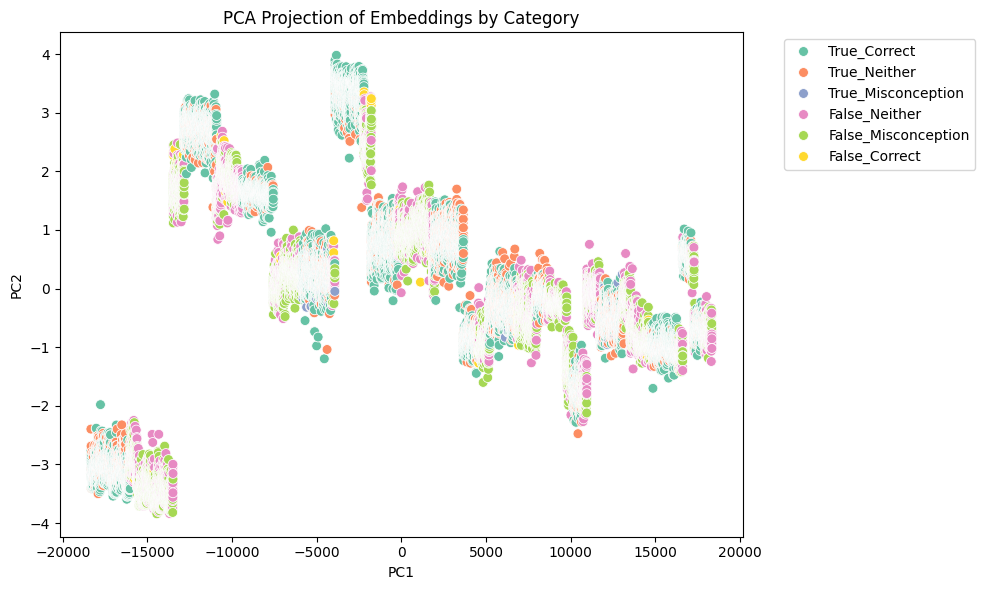

In [37]:
df = pd.read_csv("output-files\embed-store-ft.csv")  # or .xlsx if applicable

X = df.drop(columns=["Category","input_text"])  
y = df["Category"]


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Category": y
})


plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Category", palette="Set2", s=50)
plt.title("PCA Projection of Embeddings by Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
df.head(5)

,Unnamed: 0,input_text,Category,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,0,Question: What fraction of the shape is not sh...,True_Correct,0.066487,0.047491,0.002614,0.013743,0.023472,-0.027175,-0.002122,...,-0.064040,-0.113054,0.057983,0.008863,-0.085299,0.083962,0.086492,-0.042773,0.066296,0.003816
1,1,Question: What fraction of the shape is not sh...,True_Correct,0.052255,0.028769,0.007091,-0.005985,0.011644,-0.034328,-0.005050,...,-0.070016,-0.112677,0.072783,0.033693,-0.107904,0.077360,0.077511,-0.027202,0.040693,-0.000739
2,2,Question: What fraction of the shape is not sh...,True_Neither,0.045907,0.031967,0.012589,-0.000919,0.009388,-0.037308,0.003920,...,-0.061355,-0.096555,0.080163,0.019333,-0.095783,0.077401,0.064287,-0.007701,0.050280,0.000046
3,3,Question: What fraction of the shape is not sh...,True_Neither,0.051900,0.043589,0.005862,0.002029,0.015481,-0.030377,0.010795,...,-0.072593,-0.116711,0.083263,0.029997,-0.092578,0.095901,0.074251,-0.015116,0.043328,-0.010452
4,4,Question: What fraction of the shape is not sh...,True_Correct,0.060739,0.039126,-0.006546,-0.013044,0.007379,-0.029788,0.030585,...,-0.063155,-0.118424,0.063491,0.044810,-0.084208,0.064213,0.063894,-0.029274,0.044857,-0.010766


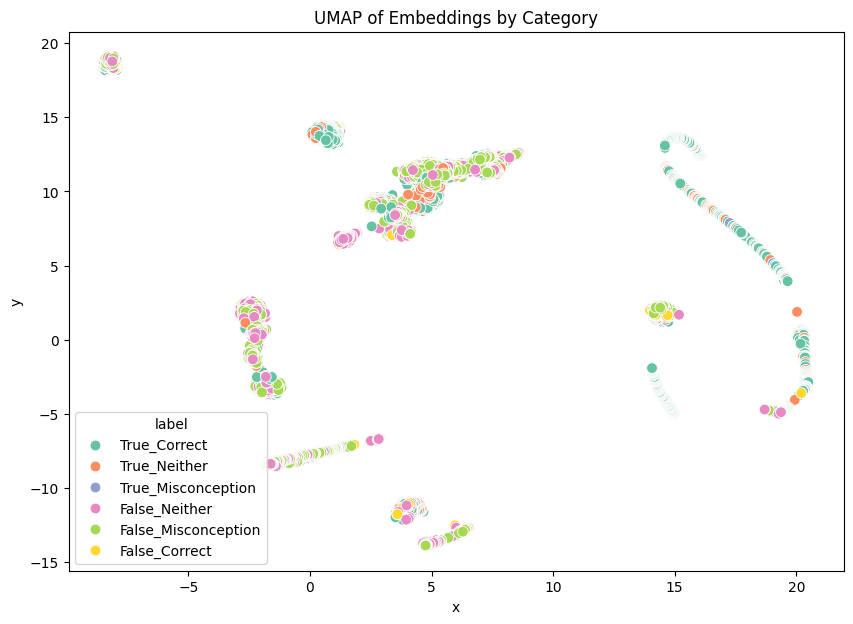

In [41]:
umap = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
X_umap = umap.fit_transform(X)

df_umap = pd.DataFrame({
    "x": X_umap[:, 0],
    "y": X_umap[:, 1],
    "label": df["Category"]
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="x", y="y", hue="label", palette="Set2", s=60)
plt.title("UMAP of Embeddings by Category")
plt.show()



d:\math-problem-ai\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


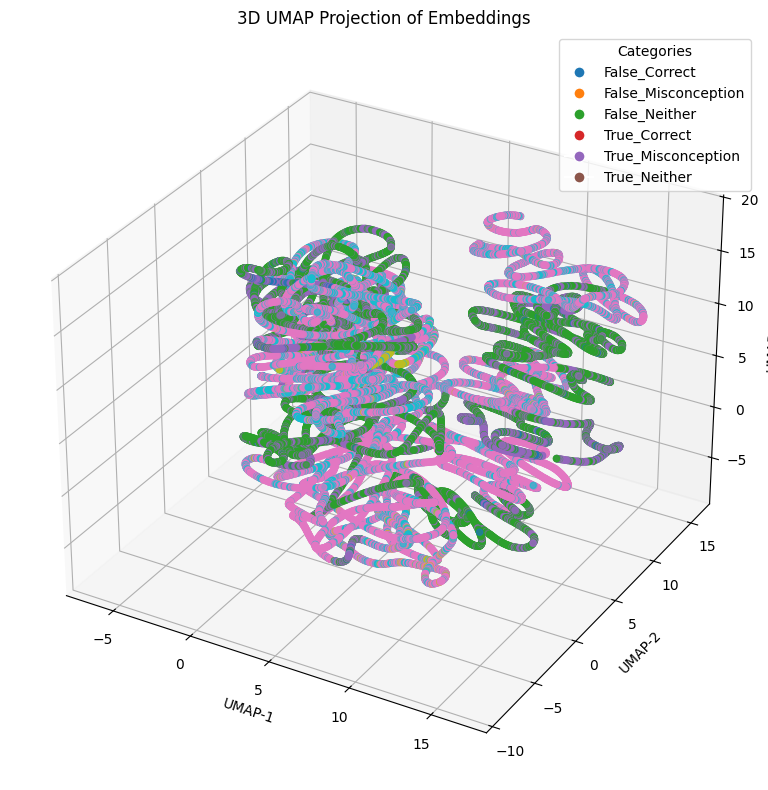

In [46]:
# UMAP in 3D
umap_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = umap_3d.fit_transform(X)

# Encode labels to colors
le = LabelEncoder()
labels_encoded = le.fit_transform(y)
label_names = le.classes_

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embeddings_3d[:, 0],
    embeddings_3d[:, 1],
    embeddings_3d[:, 2],
    c=labels_encoded,
    cmap='tab10',
    alpha=0.7
)

# Legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w',
                            label=label, markerfacecolor=plt.cm.tab10(i/10), markersize=8)
                 for i, label in enumerate(label_names)]
ax.legend(handles=legend_labels, title="Categories", loc='upper right')

ax.set_title("3D UMAP Projection of Embeddings")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

plt.tight_layout()
plt.show()